<a href="https://colab.research.google.com/github/L4ncelot1024/Learn_Deep_Learning_Le_Wagon/blob/main/Day4/02_Cat_Vs_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat vs. Dog Image Classification

In this challenge, we'll work on an image dataset of images with cat or dog and you need to build and optimize a classifier able to detect which animal is on the image.

We'll first build a simple model and evalute it. Then we'll improve it through transfer learning, i.e. while applying pre-trained weights.

## Data

### Downloading the data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
%tensorflow_version 2.x

In [ ]:
%matplotlib inline
import os
import zipfile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import pandas as pd


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-01-29 13:48:17--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.240, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  65.5MB/s    in 1.0s    

2021-01-29 13:48:18 (65.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and test datasets. (we actually the validation set here as our test and we'll extract a validation split from the training data to hyper-optimize our training and avoid overfitting)
Let's define each of these directories:

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our test cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')

# Directory with our test dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `test` directory):

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.354.jpg', 'cat.137.jpg', 'cat.30.jpg', 'cat.104.jpg', 'cat.582.jpg', 'cat.41.jpg', 'cat.329.jpg', 'cat.358.jpg', 'cat.472.jpg', 'cat.819.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `test` directories:

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total test cat images: 500
total test dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

### Inspecting the Data

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. 

Here we're loading directly the image from its file to plot it. We'll see later that we can use data generator to feed image from files to our network.

In [ ]:

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

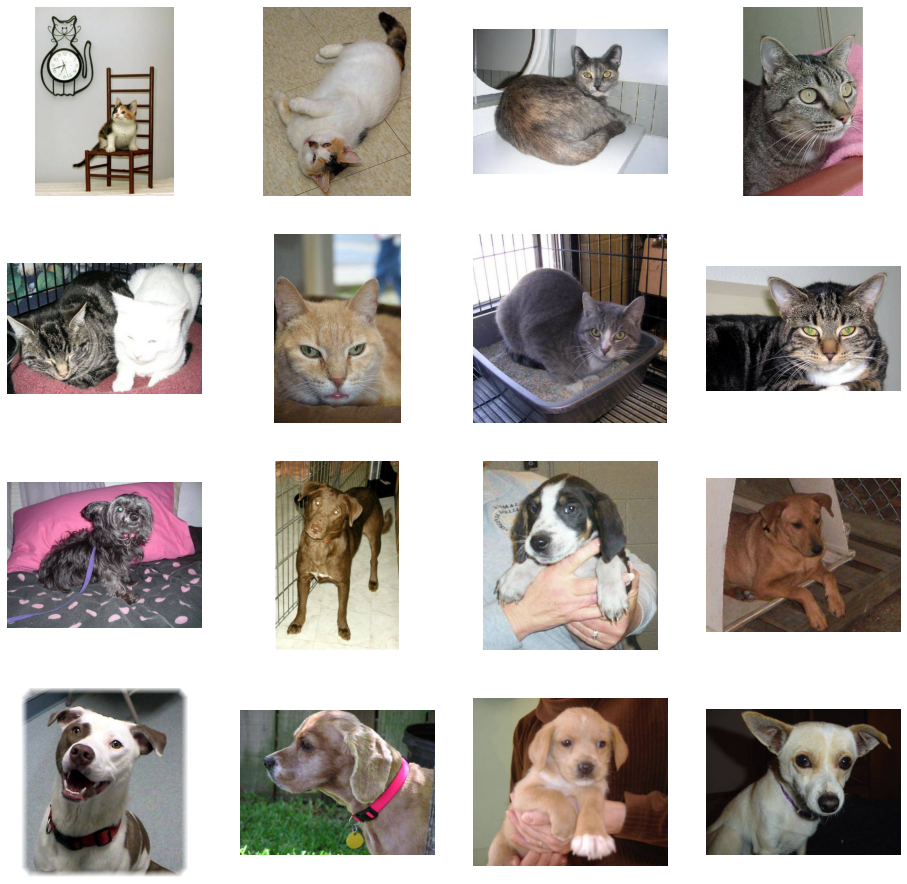

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [ ]:
# TODO: check the shape, datatypes and range of your image
# Do you have any observation? Do your data required specific pre-processing / cleaning steps?

<details>
<summary markdown='span'>View solution
</summary>

```python
for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  print(img_path)
  img = mpimg.imread(img_path)
  print(img.shape)
  print(img.dtype)
  print(np.min(img), np.max(img))
```

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the test images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [ ]:
# TODO: Prepare the data to feed into your model and to evaluate it.
#  since you're data are coming from a file, you can directly define
#  an ImageDataGenerator and then an iterator with the object method
#  .flow_from_directory()

<details>
<summary markdown='span'>Hints
</summary>
You can include in your ImageDataGenerator the `rescale` of your data.
</details>

<details>
<summary markdown='span'>Hints
</summary>
you can also for a `validation_split` in the generator and then use the argument `subset` to differentiate validation from training
</details>

<details>
<summary markdown='span'>View solution
</summary>

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255, for the train generator we set
# the validation split.
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# global settings
target_size = (150, 150)
batch_size = 20

# Flow training images in batches of 20 using train_datagen generator
print('Train Dataset')
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=target_size,  # All images will be resized to 150x150
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset='training')

print('Validation Dataset')
# Flow validation images
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

print('Test Dataset')
# Flow validation images in batches of 20 using val_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')
      

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
# All images will be rescaled by 1./255, for the train generator we set
# the validation split.
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)
 
# global settings
target_size = (150, 150)
batch_size = 20
 
# Flow training images in batches of 20 using train_datagen generator
print('Train Dataset')
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=target_size,  # All images will be resized to 150x150
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset='training')
 
print('Validation Dataset')
# Flow validation images
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')
 
print('Test Dataset')
# Flow validation images in batches of 20 using val_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

Train Dataset
Found 1600 images belonging to 2 classes.
Validation Dataset
Found 400 images belonging to 2 classes.
Test Dataset
Found 1000 images belonging to 2 classes.


# Modeling: Baseline

## Architecture

Let's code up the architecture. We will stack 3 {convolution + relu + maxpooling} modules. Our convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.


In [ ]:
# TODO: build your first model to set a baseline on the dataset, you should reach
#  at least 70% Accuracy on the tet set
#  Since you're dealing with 2000 images you can stack the common CNN
#  architectures (CNN-MaxPooling-Dropout) for 3 layers 

<details>
<summary markdown='span'>Hints
</summary>
You're dealing with a binary classification problem (two classes) so adapt your loss to a binary_crossentropy and the output shape of your model
</details>

<details>
<summary markdown='span'>View solution
</summary>

```python

from tensorflow.keras import layers
from tensorflow.keras import Model

layers = [
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, 3, 1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, 3, 1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, 3, 1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
]

# Training
model = tf.keras.Sequential(layers)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
```

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
 
layers = [
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, 3, 1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, 3, 1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, 3, 1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
]
 
# Training
model = tf.keras.Sequential(layers)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Let's summarize the model architecture:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the feature map.

## Training

In [ ]:
# TODO: train for 20 epochs the model



<details>
<summary markdown='span'>View solution
</summary>

```python
num_epochs = 20

history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,  # 2000 images = batch_size * steps
      epochs=num_epochs,
      validation_data=validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      verbose=2)
```

In [ ]:
num_epochs = 20
 
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,  # 2000 images = batch_size * steps
      epochs=num_epochs,
      validation_data=validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      verbose=2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
80/80 - 13s - loss: 0.7539 - accuracy: 0.5269 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
80/80 - 5s - loss: 0.6841 - accuracy: 0.5569 - val_loss: 0.6762 - val_accuracy: 0.5975
Epoch 3/20
80/80 - 5s - loss: 0.6756 - accuracy: 0.5606 - val_loss: 0.6834 - val_accuracy: 0.5350
Epoch 4/20
80/80 - 5s - loss: 0.6475 - accuracy: 0.6075 - val_loss: 0.6383 - val_accuracy: 0.6150
Epoch 5/20
80/80 - 5s - loss: 0.6722 - accuracy: 0.5494 - val_loss: 0.6872 - val_accuracy: 0.4925
Epoch 6/20
80/80 - 5s - loss: 0.6646 - accuracy: 0.5756 - val_loss: 0.6360 - val_accuracy: 0.6350
Epoch 7/20
80/80 - 5s - loss: 0.6299 - accuracy: 0.6256 - val_loss: 0.6245 - val_accuracy: 0.6100
Epoch 8/20
80/80 - 5s - loss: 0.6022 - accuracy: 0.6625 - val_loss: 0.6037 - val_accuracy: 0.6375
Epoch 9/20
80/80 - 5s - loss: 0.5937 - accuracy: 0.6888 - val_loss: 0.5848 - val_accuracy: 0.6775
Epoch 10/20
80/80 - 5s - loss: 0.5863 - accuracy: 0.6888 - val_loss: 0.5726 - val_accuracy: 0.6850
Epoch 11/20
80/80 

## Evaluation

In [ ]:
# TODO: print test metrics of your model and plot the metrics curves


<details>
<summary markdown='span'>View solution
</summary>

```python
test_loss, accuracy_test_nn = model.evaluate(test_generator, verbose=2)
print(f'Test model accuracy: {accuracy_test_nn}')

history_df = pd.DataFrame(history.history).reset_index().rename(columns={'index': 'epochs'})
history_df.tail()

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

for i, metric in enumerate(['loss', 'accuracy']):
  ax = axes[i]
  history_df.plot('epochs', f'{metric}', color='g', label='train', ax=ax)
  history_df.plot('epochs', f'val_{metric}', color='r', label='val', ax=ax)
  ax.set_ylabel(metric)
plt.show()

```

As you can see, we are **overfitting** like it's getting out of fashion. Our training accuracy gets close to 100% (!) while our validation accuracy stalls as 70%. Our validation loss reaches its minimum after only five epochs.

Since we have a relatively small number of training examples (2000), overfitting should be our number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning: given that we are fitting the parameters of our model to a given dataset, how can we make sure that the representations learned by the model will be applicable to data never seen before? How do we avoid learning things that are specific to the training data?

In the next exercise, we'll look at ways to prevent overfitting in the cat vs. dog classification model with transfer learning.